In [140]:
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

sns.set_theme()
%matplotlib inline

In [4]:
json_results_file = '../predictions/multiple_imputation_median_pooling.json'

predictions = None
with open(json_results_file, 'r') as file:
    data_json = json.load(file)
    for model_full_name, df_data in data_json.items():
        model_short_name = model_full_name.split('_')[0]
        predictions = pd.DataFrame(df_data)
        break

predictions.head()

,y_test,binary_predictions,probabilities,patient_id
0,0,0,0.151226,25312
1,0,1,0.633058,59342
2,0,0,0.007471,50777
3,0,0,0.049166,46918
4,0,0,0.012339,34377


In [5]:
data_file = '../data/training_v2.csv'
data = pd.read_csv(data_file)
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [6]:
predictions = predictions.join(data, on='patient_id', rsuffix='_data', how='left')[['y_test', 'probabilities', 'age', 'ethnicity', 'gender']]
predictions = predictions.rename(columns={'y_test': 'labels', 'probabilities': 'predictions'})
predictions.head()

,labels,predictions,age,ethnicity,gender
0,0,0.151226,57.0,African American,F
1,0,0.633058,48.0,Caucasian,M
2,0,0.007471,34.0,Caucasian,F
3,0,0.049166,60.0,Caucasian,F
4,0,0.012339,80.0,Caucasian,F


In [7]:
data = pd.read_csv("XGBClassifier_predictions.csv")

In [8]:
def plot_roc_curves(df, column_name, label_col="labels", pred_col="predictions", value_names={}):
  unique_values = sorted(df[column_name].unique())

  plt.figure(figsize=(10, 6))
  for i, value in enumerate(unique_values):
    group_data = df[df[column_name] == value]
    y_true = group_data[label_col]
    y_pred = group_data[pred_col]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    label = value_names.get(value, value)  # Use custom label if available
    plt.plot(fpr, tpr, label=label)

  # Add subtle y=x line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)

  # Customize plot and display
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"ROC Curves by {column_name}")
  plt.legend(title=column_name)
  plt.grid(True)
  plt.show()

In [144]:
def plot_precision_recall_curves(df, column_name, label_col="labels", pred_col="predictions", value_names={}):
  unique_values = sorted(df[column_name].unique())

  plt.figure(figsize=(10, 6))
  for i, value in enumerate(unique_values):
    group_data = df[df[column_name] == value]
    y_true = group_data[label_col]
    y_pred = group_data[pred_col]
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    label = value_names.get(value, value)  # Use custom label if available
    plt.plot(recall, precision, label=label)

  # Customize plot and display
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title(f"Precision-Recall Curves by {column_name}")
  plt.legend(title=column_name)
  plt.grid(True)
  plt.show()

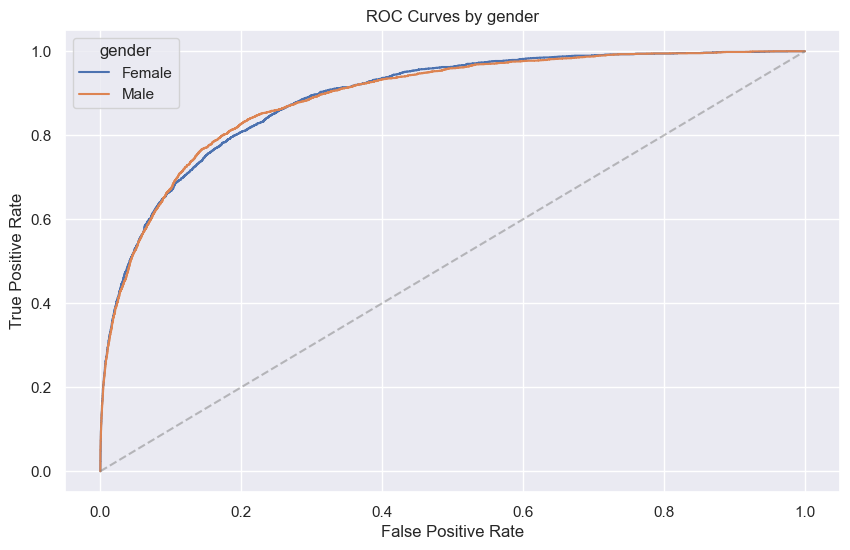

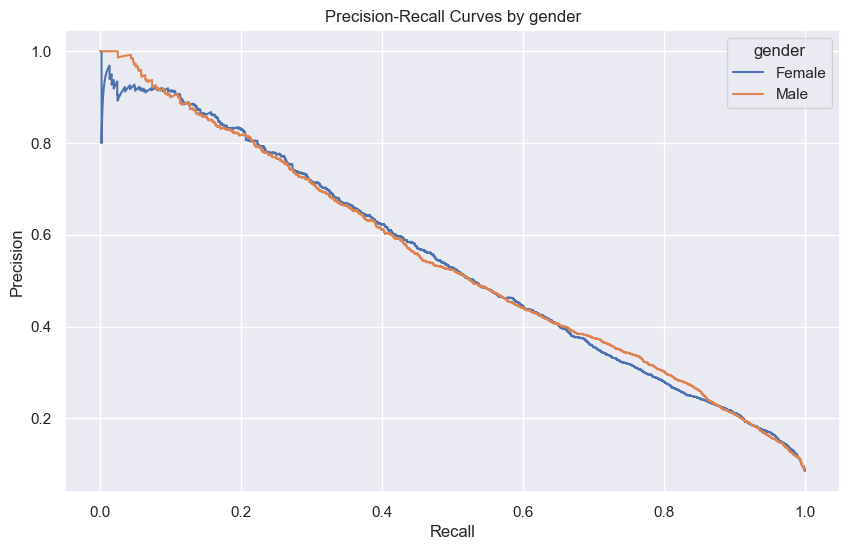

In [147]:
gender_labels = {
  'F': 'Female',
  'M': 'Male'
}

data_gender_drop_na = pd.DataFrame(predictions)
data_gender_drop_na.dropna(inplace=True)
plot_roc_curves(data_gender_drop_na, 'gender', value_names=gender_labels)
plot_precision_recall_curves(data_gender_drop_na, 'gender', value_names=gender_labels)

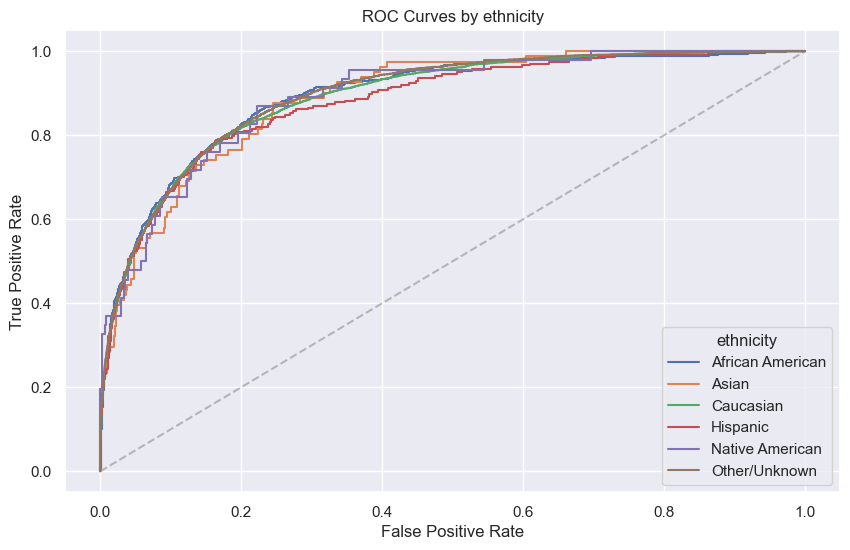

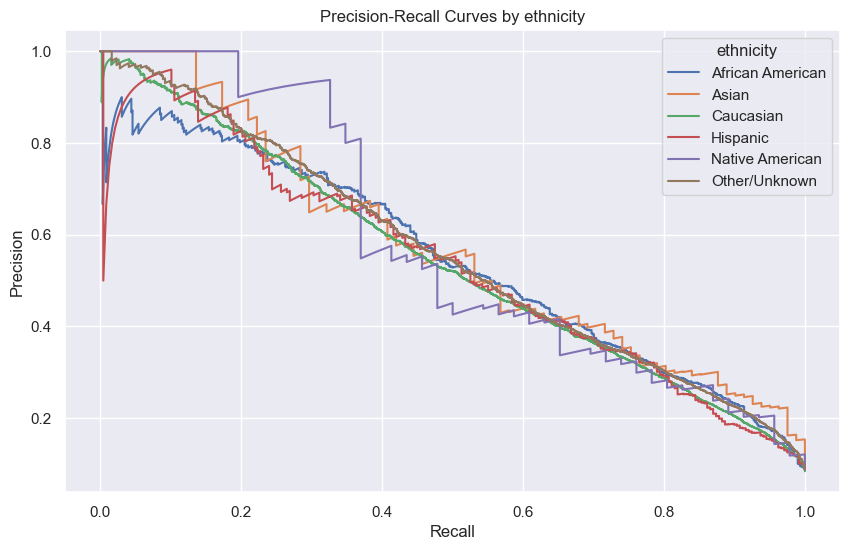

In [148]:
predictions['ethnicity'] = predictions['ethnicity'].fillna('Other/Unknown')
plot_roc_curves(predictions, 'ethnicity')
plot_precision_recall_curves(predictions, 'ethnicity')

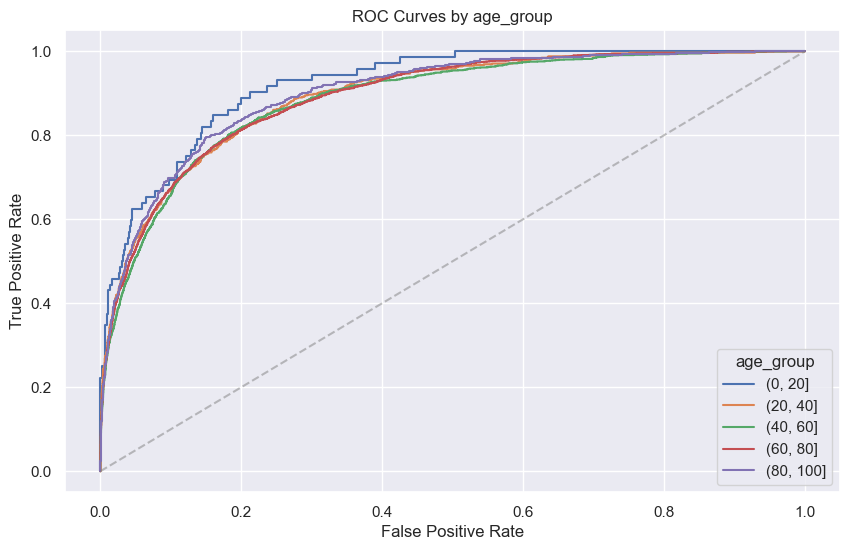

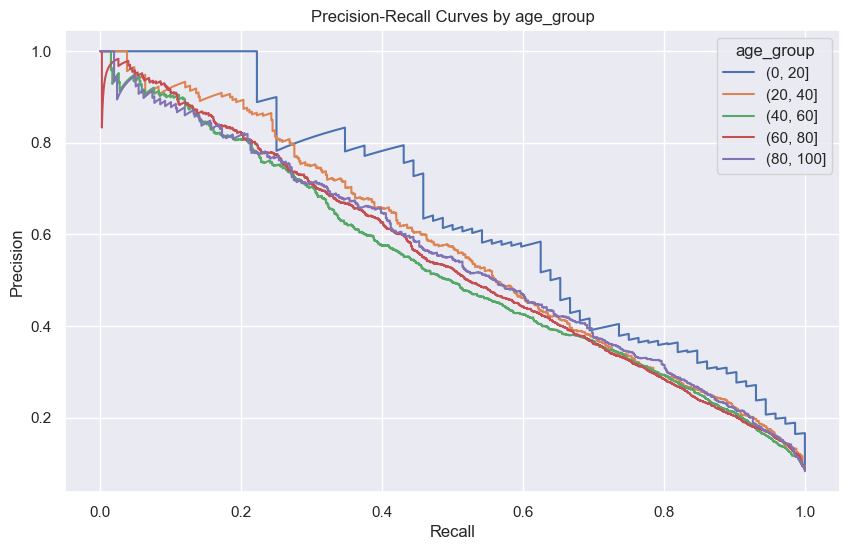

In [149]:
# Define age groups with 20-year steps
age_groups = range(0, 101, 20)
age_groups_labels = [pd.Interval(left=b, right=b+20) for b in range(0, 101, 20)]

# Use pd.cut to create the age group column based on boundaries and labels
data_with_age_groups = predictions.copy()

# data_with_age_groups['age_group'] = pd.cut(data_with_age_groups['age'], age_groups, labels=age_groups[:-1])
data_with_age_groups['age_group'] = pd.cut(data_with_age_groups['age'], age_groups, labels=age_groups_labels[:-1])
data_with_age_groups.dropna(inplace=True)

plot_roc_curves(data_with_age_groups, 'age_group')
plot_precision_recall_curves(data_with_age_groups, 'age_group')

In [12]:
data_with_age_groups.to_csv('XGBClassifier_predictions_with_protected_groups.csv')

## Multi-Calibration

In [282]:
def calculate_calibration_in_the_large(subgroup_df: pd.DataFrame, predictions_column_name, subgroup_nudges_dict):
    """Calculates the odds ratio for a given subgroup using your formula.

    Args:
        subgroup_df (pd.DataFrame): A DataFrame containing data for a specific subgroup.

    Returns:
        float: The odds ratio for the subgroup using your formula.
    """

    nudge = 0
    if subgroup_nudges_dict is not None:
        subgroup_group_by = subgroup_df.groupby(['age_group', 'gender', 'ethnicity']).count().reset_index()
        _, group = next(subgroup_group_by.iterrows())
        subgroup_id = str(group.values[:3])
        nudge = subgroup_nudges_dict[subgroup_id]['nudge']
        print(f'subgroup: {subgroup_id}, nudge: {nudge}')
    
    avg_prediction = (subgroup_df[predictions_column_name] + nudge).mean()
    avg_outcome = subgroup_df["labels"].mean()

    if avg_prediction == 1 or avg_outcome == 0 or avg_outcome == 1:
        # Handle cases where division by zero would occur
        return None

    # Calculate odds ratio using your formula
    calibration_in_the_large = (avg_prediction / (1 - avg_prediction)) / (avg_outcome / (1 - avg_outcome))

    return calibration_in_the_large

In [322]:
data_with_age_groups['calibrated_predictions'] = data_with_age_groups['predictions']
subgroups_group_by = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])
# subgroups_calibration_groups_by = subgroups_group_by.sample(frac=.2, random_state=2)
subgroups_calibration_groups_by = data_with_age_groups
subgroups_validation_groups_by = data_with_age_groups[~data_with_age_groups.index.isin(subgroups_calibration_groups_by.index.to_list())]
subgroups_df = subgroups_group_by.count().reset_index()

protected_groups_dict = { str(subgroup.values[:3]): {'nudge': 0} for index, subgroup in subgroups_df.iterrows()}
protected_groups_dict

/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/1948605860.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups_group_by = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])


{"[Interval(0, 20, closed='right') 'F' 'African American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Asian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Caucasian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Hispanic']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Native American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Other/Unknown']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'African American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Asian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Caucasian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Hispanic']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Native American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Other/Unknown']": {'nudge': 0},
 "[Interval(20, 40, closed='right') 'F' 'African American']": {'nudge': 0},
 "[Interval(20, 40, closed='right') 'F' 'Asian']": {'nudge': 0},
 "[Interval(20, 40,

In [323]:
alpha = 0.0005
done = False
while not done:
    done = True
    for group_index, subgroup in subgroups_df.iterrows():
        subgroup_df = subgroups_calibration_groups_by.loc[(data_with_age_groups['age_group'] == subgroup['age_group']) & (data_with_age_groups['gender'] == subgroup['gender']) & (data_with_age_groups['ethnicity'] == subgroup['ethnicity']),]
        sum_y = subgroup_df['labels'].sum()
        sum_p = (subgroup_df['predictions'] + protected_groups_dict[str(subgroup.values[:3])]['nudge']).sum()
        violation = (sum_y - sum_p) / subgroup_df.shape[0]
        print(f'subgroup: {subgroup.values}, violation: {violation}, count: {subgroup_df.shape[0]}')
        if np.abs(violation) > alpha:
            protected_groups_dict[str(subgroup.values[:3])]['nudge'] += violation * 0.05
            # data_with_age_groups.loc[(data_with_age_groups['age_group'] == subgroup['age_group']) & (data_with_age_groups['gender'] == subgroup['gender']) & (data_with_age_groups['ethnicity'] == subgroup['ethnicity']), 'calibrated_predictions'] += violation
            done = False

subgroup: [Interval(0, 20, closed='right') 'F' 'African American' 62 62 62 62], violation: 0.048527393835566694, count: 62
subgroup: [Interval(0, 20, closed='right') 'F' 'Asian' 6 6 6 6], violation: -0.07287176698446274, count: 6
subgroup: [Interval(0, 20, closed='right') 'F' 'Caucasian' 266 266 266 266], violation: 0.012650648154724473, count: 266
subgroup: [Interval(0, 20, closed='right') 'F' 'Hispanic' 17 17 17 17], violation: -0.0163075774360229, count: 17
subgroup: [Interval(0, 20, closed='right') 'F' 'Native American' 13 13 13 13], violation: -0.03744132025167346, count: 13
subgroup: [Interval(0, 20, closed='right') 'F' 'Other/Unknown' 37 37 37 37], violation: -0.02633256249985582, count: 37
subgroup: [Interval(0, 20, closed='right') 'M' 'African American' 49 49 49 49], violation: -0.0021366931840169187, count: 49
subgroup: [Interval(0, 20, closed='right') 'M' 'Asian' 6 6 6 6], violation: -0.07324006594717503, count: 6
subgroup: [Interval(0, 20, closed='right') 'M' 'Caucasian' 25

In [324]:
# subgroups_after_calibration_df = subgroups_validation_groups_by.groupby(['age_group', 'gender', 'ethnicity'])
subgroups_after_calibration_df = subgroups_calibration_groups_by.groupby(['age_group', 'gender', 'ethnicity'])
calibration_in_the_large = pd.DataFrame()
calibration_in_the_large['before_calibration'] = np.log(subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions', None)))
calibration_in_the_large['after_calibration'] = np.log(subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions', protected_groups_dict)))
calibration_in_the_large.dropna(inplace=True)

subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], nudge: 0.04804753726691134
subgroup: [Interval(0, 20, closed='right') 'F' 'Asian'], nudge: -0.07239371775923405
subgroup: [Interval(0, 20, closed='right') 'F' 'Caucasian'], nudge: 0.012150959015283702
subgroup: [Interval(0, 20, closed='right') 'F' 'Hispanic'], nudge: -0.015809158413564183
subgroup: [Interval(0, 20, closed='right') 'F' 'Native American'], nudge: -0.03696284706641269
subgroup: [Interval(0, 20, closed='right') 'F' 'Other/Unknown'], nudge: -0.025850687565560092
subgroup: [Interval(0, 20, closed='right') 'M' 'African American'], nudge: -0.0016539382535509307
subgroup: [Interval(0, 20, closed='right') 'M' 'Asian'], nudge: -0.07275960062801776
subgroup: [Interval(0, 20, closed='right') 'M' 'Caucasian'], nudge: -0.006518464971303743
subgroup: [Interval(0, 20, closed='right') 'M' 'Hispanic'], nudge: 0.06706622181232615
subgroup: [Interval(0, 20, closed='right') 'M' 'Native American'], nudge: -0.0024931692975759

/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/1484869660.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups_after_calibration_df = subgroups_calibration_groups_by.groupby(['age_group', 'gender', 'ethnicity'])
/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/2162901619.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroup_group_by = subgroup_df.groupby(['age_group', 'gender', 'ethnicity']).count().reset_index()
/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/2162901619.py:13: FutureWarning: The default of observed=False is deprecated and wi

Max calibration: subpopulation - (Interval(20, 40, closed='right'), 'F', 'Native American'), value: 1.7552330627762383, index: 13
Min calibration: subpopulation - (Interval(80, 100, closed='right'), 'M', 'Native American'), value: -0.9140203247273713, index: 55


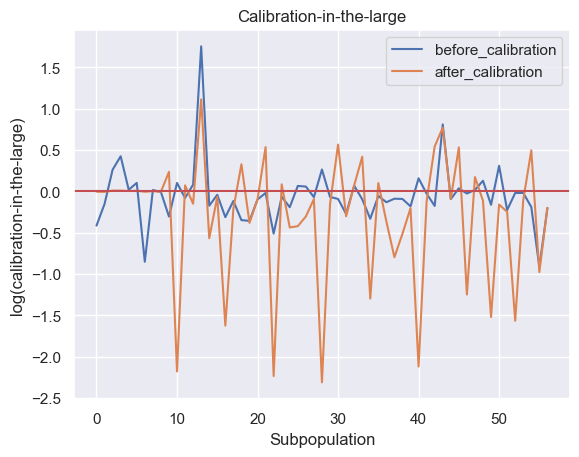

In [325]:
calibration_in_the_large.reset_index().plot(title='Calibration-in-the-large', ylabel='log(calibration-in-the-large)', xlabel='Subpopulation')
plt.axhline(y=0, color='r')

max_subgroup_before_index = calibration_in_the_large['before_calibration'].argmax()
max_subgroup_before_value = calibration_in_the_large.loc[calibration_in_the_large.index[max_subgroup_before_index], 'before_calibration']
max_subgroup_before_name = calibration_in_the_large.index[max_subgroup_before_index]
print(f'Max calibration: subpopulation - {max_subgroup_before_name}, value: {max_subgroup_before_value}, index: {max_subgroup_before_index}')

min_subgroup_before_index = calibration_in_the_large['before_calibration'].argmin()
min_subgroup_before_value = calibration_in_the_large.loc[calibration_in_the_large.index[min_subgroup_before_index], 'before_calibration']
min_subgroup_before_name = calibration_in_the_large.index[min_subgroup_before_index]
print(f'Min calibration: subpopulation - {min_subgroup_before_name}, value: {min_subgroup_before_value}, index: {min_subgroup_before_index}')

<Axes: title={'center': 'Clibration-in-the-large density'}, ylabel='Density'>

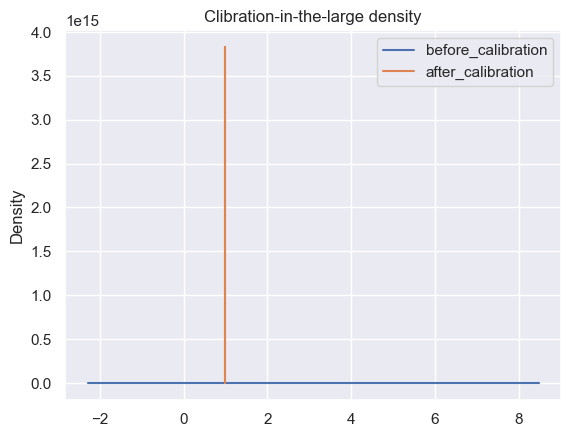

In [158]:
calibration_in_the_large.plot(kind='density', title='Clibration-in-the-large density')

In [139]:
print(json.dumps(protected_groups_dict, indent=4))

{
    "[Interval(0, 20, closed='right') 'F' 'African American']": {
        "nudge": 0.048527393835566694
    },
    "[Interval(0, 20, closed='right') 'F' 'Asian']": {
        "nudge": -0.07287176698446274
    },
    "[Interval(0, 20, closed='right') 'F' 'Caucasian']": {
        "nudge": 0.012650648154724473
    },
    "[Interval(0, 20, closed='right') 'F' 'Hispanic']": {
        "nudge": -0.0163075774360229
    },
    "[Interval(0, 20, closed='right') 'F' 'Native American']": {
        "nudge": -0.03744132025167346
    },
    "[Interval(0, 20, closed='right') 'F' 'Other/Unknown']": {
        "nudge": -0.02633256249985582
    },
    "[Interval(0, 20, closed='right') 'M' 'African American']": {
        "nudge": -0.0021366931840169187
    },
    "[Interval(0, 20, closed='right') 'M' 'Asian']": {
        "nudge": -0.07324006594717503
    },
    "[Interval(0, 20, closed='right') 'M' 'Caucasian']": {
        "nudge": -0.007004905504800263
    },
    "[Interval(0, 20, closed='right') 'M' 'Hi